# Compton Scattering

This example demonstrates the beam angle feature by simulating a Compton scattering teaching experiment.
We will here measure the photon energy as a function of scattering angle.
The photon energy is measured in a (crudely simulated) NaI spectrometer, and the scattering angle is controlled by setting the angle of the initial photon beam together with the collimator.

The photons will come from a Cs137 source, which $\beta^+$-decays to Ba137, which has a strong line at 661.657 keV.
We will only use the 661.657 keV line.


## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import stats
import ROOT
import os
import copy

Welcome to JupyROOT 6.28/06


In [2]:
#%matplotlib notebook

# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [3]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

## Physics setup

In [4]:
### Basic simulation parameters ###

QUIET = False
TRYLOAD = True #Try to load already existing data instead of recomputing?
NUM_THREADS = 16

baseSimSetup = {}
baseSimSetup["PHYS"] = "QGSP_BERT_EMZ"

#Note: With 10M particles, it takes about 30 minutes to run a simulation
baseSimSetup["N"] = 10000000

baseSimSetup["BEAM"] = 'gamma';
baseSimSetup["ENERGY"] = 661.657e-3;

baseSimSetup["BGMAT"] = "G4_AIR";

#Disable the default target
baseSimSetup["THICK"] = 0.0
baseSimSetup["ZOFFSET"]=-500.0 #[mm]
baseSimSetup["BEAMANGLE"] = 45.0 #[deg]

# "Beamline" elements
baseSimSetup["MAGNET"] = []
#Target pin
m1 = {}
m1["pos"]      = 0.0
m1["type"]     = "TARGETR"
m1["length"]   = 80.0 #[mm] Make it symmetric, same amount above and below axis
m1["gradient"] = 0.0
m1["keyval"] = {}
m1["keyval"]["material"] = "G4_STAINLESS-STEEL"
m1["keyval"]["radius"]    = 7.0 #[mm]
m1["keyval"]["xRot"]      = 90.0 #[deg] Standing on an end, round side facing the sky not the beam
baseSimSetup["MAGNET"].append(m1)

m2 = {}
m2["type"]     = "COLLIMATORHV"
m2["length"]   = 150.0 #[mm] Make it symmetric, same amount above and below axis
m2["pos"]      = m2["length"]/2+70.0 #[mm]
m2["gradient"] = 0.0
m2["keyval"] = {}
m2["keyval"]["material"] = "G4_Fe"
m2["keyval"]["gap"]    = 14.0 #[mm]
m2["keyval"]["jawThick"] = 55.0 #[mm]
m2["keyval"]["jawHeight"] = 125.0 #[mm] 2x axis height above table
m2["keyval"]["HV"] = 'H'
baseSimSetup["MAGNET"].append(m2)

m3 = {}
m3["type"]     = "SHIELDEDSCINTILLATOR"
m3["length"]   = 254.0 #[mm]
m3["pos"]      = m3["length"]/2.0+m2["length"]/2.0+m2["pos"] #[mm]
m3["gradient"] = 0.0
m3["keyval"] = {}
m3["keyval"]["scintMat"]  = 'G4_SODIUM_IODIDE'
m3["keyval"]["shieldMat"] = 'G4_Pb'
m3["keyval"]["rScint"]    = 25.0 #[mm]
m3["keyval"]["lScint"]    = 50.0 #[mm]
m3["keyval"]["zScint"]    =  -m3["length"]/2.0+50.0+m3["keyval"]["lScint"]/2.0
m3["keyval"]["riShield"]    = 58/2.0 #[mm]
m3["keyval"]["roShield"]    = 125/2.0 #[mm]
baseSimSetup["MAGNET"].append(m3)

baseSimSetup["WORLDSIZE"] = 1000.0 #[mm], x-y size of the world. Make it big.

baseSimSetup["DIST"] = 'NONE' #Perfect-detector position [mm] 

baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files

#Lowest energy particles to consider for analysis
#E_CUTOFF = baseSimSetup["ENERGY"]*0.9;

#Store the .root files in a subfolder from MiniScatter/examples, to be easy to find
baseSimSetup["OUTFOLDER"]=os.path.join(os.getcwd(),"Compton")


In [5]:
# Test simulation at 0 degrees
baseSimSetup_test = baseSimSetup.copy()
baseSimSetup_test["BEAMANGLE"] = 0.0 #[deg]
baseSimSetup_test["OUTNAME"] = "test0"
baseSimSetup_test["N"] = 100000

(twiss_test, numPart_test, objects_test) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_3_edep","metadata"])

Found a file at '/mn/fys-server1/a9/kyrrens/MiniScatter/examples/Compton/test0.root', loading!


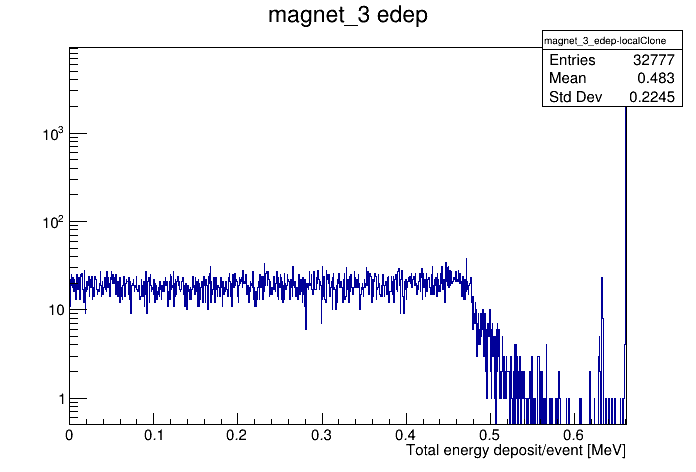

In [6]:
c1 = ROOT.TCanvas()
ROOT.gPad.SetLogy()
objects_test["magnet_3_edep"].Draw()
c1.Draw()

In [7]:
# Test simulation at 20 degrees
baseSimSetup_test20 = baseSimSetup.copy()

baseSimSetup_test20["BEAMANGLE"] = 20.0 #[deg]
baseSimSetup_test20["OUTNAME"] = "test20"

(twiss_test20, numPart_test20, objects_test20) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test20, tryload=TRYLOAD,\
    getObjects=["magnet_1_edep","magnet_3_edep","metadata"])

Found a file at '/mn/fys-server1/a9/kyrrens/MiniScatter/examples/Compton/test20.root', loading!


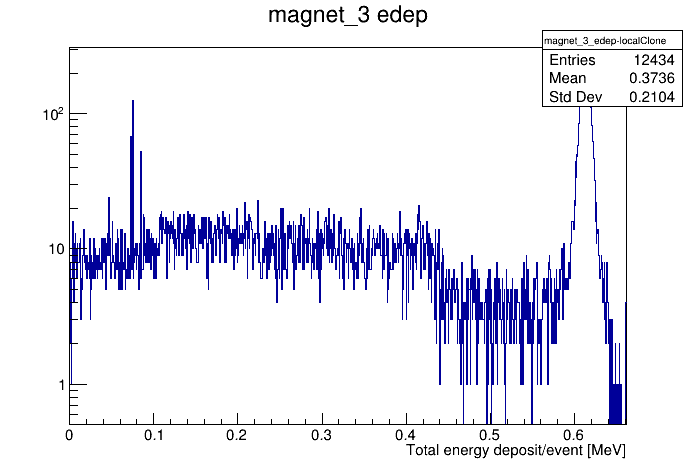

In [8]:
c1 = ROOT.TCanvas()
ROOT.gPad.SetLogy()
objects_test20["magnet_3_edep"].Draw()
c1.Draw()

In [9]:
#Angle scan
baseSimSetup_angleScan = copy.deepcopy(baseSimSetup)

angleScan = [0,5,10,20,30,40,50,60,70,80];

del baseSimSetup_angleScan["BEAMANGLE"]
del baseSimSetup_angleScan["OUTFOLDER"]

(twiss_angleScan, numpart_angleScan, objects_angleScan, analysisOutput_angleScan) =\
    miniScatterScanner.ScanMiniScatter("BEAMANGLE",angleScan,\
                                       baseSimSetup_angleScan, COMMENT="angleScan",\
                                       tryLoad=TRYLOAD, getObjects=["magnet_3_edep"],\
                                       NUM_THREADS=NUM_THREADS)
                                   

LoadFile filename and status: 'SaveSim_BEAMANGLE_angleScan.h5' True
Loading...
Scan variable ranges match, let's load!
Auxillary ROOT file SaveSim_BEAMANGLE_angleScan.root loaded.
Loaded! That was fast.


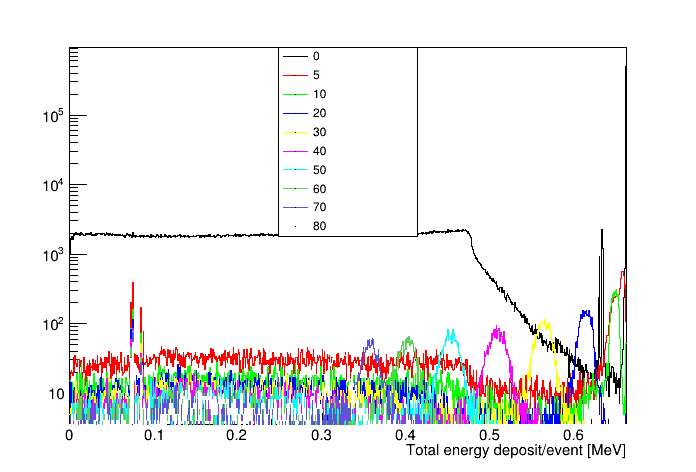

In [10]:
c1 = ROOT.TCanvas()
ROOT.gPad.SetLogy()
leg = ROOT.TLegend(0.4, 0.5, 0.6,0.9)

#meanEdep_rScan = []

#colors = [ROOT.kBlue, ROOT.kRed, ROOT.kGreen, ROOT.kOrange, ROOT.kGray, ROOT.kPurple, ROOT.kMagenta, ]

for obj,i in zip(objects_angleScan["magnet_3_edep"],range(len(objects_angleScan["magnet_3_edep"]))):
    #meanEdep_angleScan.append(obj.GetMean())
    if i == 0:
        obj.Draw()
        obj.SetStats(False)
        obj.SetTitle("")
    else:
        obj.Draw("same")
    obj.SetLineColor(i+1)
    leg.AddEntry(obj,str(angleScan[i]))
leg.Draw()
c1.Draw()
